In [1]:
# !pip install dust_extinction
# make sure to install all required modules including pahfit from github
# !pip install git+https://github.com/PAHFIT/pahfit.git

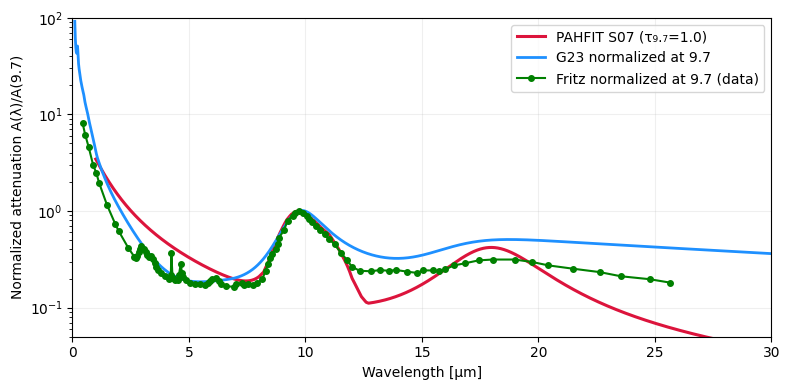

In [3]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from dust_extinction.parameter_averages import G23
import os


#loading comparision data for different attenuations

# load fritz   https://iopscience.iop.org/article/10.1088/0004-637X/737/2/73/pdf
fritz_path = "../data/fritz.dat"
fritz = np.loadtxt(fritz_path)
fritz_wav = fritz[:,0]
fritz_val = fritz[:,1]

# normalize fritz at nearest point to 9.7
idx9_F = np.argmin(np.abs(fritz_wav - 9.7))
fritz_shape = fritz_val / fritz_val[idx9_F]

# load lutz99   https://iopscience.iop.org/article/10.1088/0004-637X/737/2/73/pdf
lutz99_path = "../data/lutz99.dat"
lutz99 = np.loadtxt(lutz99_path)
lutz99_wav = lutz99[:,0]
lutz99_val = lutz99[:,1]

# normalize fritz at nearest point to 9.7
idx9_L = np.argmin(np.abs(lutz99_wav - 9.7))
lutz99_shape = lutz99_val / lutz99_val[idx9_L]

# build G23 and normalize at 9.7       
#https://iopscience.iop.org/article/10.3847/1538-4357/accb59/pdf     [figure 8 for Rv]
#https://dust-extinction.readthedocs.io/en/stable/index.html

ext = G23(Rv=2.5)                     #[2.5,3.1,4.0,5.5]
w = np.logspace(np.log10(0.1), np.log10(30.0), 4000) * u.micron
g23 = np.asarray(ext(w))
A9p7 = float(ext(9.7 * u.micron))
g23_norm9 = g23 / A9p7


#############################################################
try:
    from pahfit.fitters.ap_components import S07_attenuation
    use_pahfit = True
except Exception:
    use_pahfit = False

# --- PAHFIT (S07 mixed attenuation) ---
# wavelength grid (µm)
w_pahfit = np.linspace(1.0, 30.0, 4000)
tau_peak = 1.0
model = S07_attenuation(tau_sil=tau_peak)
Att = model(w_pahfit)
A_lambda = -2.5 * np.log10(Att)
A_norm = A_lambda / np.interp(9.7, w_pahfit, A_lambda)

# --- Plot all together ---
plt.figure(figsize=(8,4))

# PAHFIT curve
plt.plot(w_pahfit, A_norm, '-', lw=2.2, color='crimson', label=f'PAHFIT S07 (τ₉.₇={tau_peak})')

# Literature curves
plt.plot(w.to(u.micron).value, g23_norm9, '-', lw=2, color='dodgerblue', label='G23 normalized at 9.7')
plt.plot(fritz_wav, fritz_shape, 'o-', ms=4, color='green', label='Fritz normalized at 9.7 (data)')
#plt.plot(lutz99_wav, lutz99_shape, '-', lw=1.8, color='orange', label='Lutz99 normalized at 9.7 (data)')

# Formatting
plt.yscale('log')
plt.xlim(0, 30)
plt.ylim(0.05, 100)
plt.xlabel('Wavelength [µm]')
plt.ylabel('Normalized attenuation A(λ)/A(9.7)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Raw codes that I did first and might require fallback

These are the codes that I initially used to create this plot. They have other options like a fallback and custom modelling for PAHFIT, but if you have PAHFIT, the above would be more appropriate. These codes also have things that I tried and tested. For example, the plots after I successfully incorporated these models into pahfit and plot from the pahfit instead of calling them separately.



## Model.py
#### This is what the model file for pahfit has for attenuation 
class S07_attenuation(Fittable1DModel):
    """
    Smith, Draine, et al. (2007) kvt attenuation model calculation.
    Calculation is for a fully mixed geometrically model.
    Uses an extinction curve based on the silicate profiles from
    Kemper, Vriend, & Tielens (2004, apJ, 609, 826).
    Constructed as a weighted sum of two components: silicate profiles,
    and an exponent 1.7 power-law.

    Attenuation curve for a mixed case calculated from
    .. math::

        Att(x) = \\frac{1 - e^{-\\tau_{x}}}{\\tau_{x}}

    Parameters
    ----------
    kvt_amp : float
      amplitude
    """

    # Attenuation tau
    tau_sil = Parameter(description="kvt term: amplitude", default=1.0, min=0.0, max=10)

    @staticmethod
    def kvt(in_x):
        """
        Output the kvt extinction curve
        """
        # fmt: off
        kvt_wav = np.array([8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.7,
                            9.75, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0,
                            11.2, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.6,
                            12.7])

        kvt_int = np.array([.06, .09, .16, .275, .415, .575, .755, .895, .98,
                            .99, 1.0, .99, .94, .83, .745, .655, .58, .525,
                            .43, .35, .27, .20, .13, .09, .06, .045, .04314])
        # fmt: on

        # Extend kvt profile to shorter wavelengths
        if min(in_x) < min(kvt_wav):
            kvt_wav_short = in_x[in_x < min(kvt_wav)]
            kvt_int_short_tmp = min(kvt_int) * np.exp(
                2.03 * (kvt_wav_short - min(kvt_wav))
            )
            # Since kvt_int_shoft_tmp does not reach min(kvt_int),
            # we scale it to stitch it.
            kvt_int_short = kvt_int_short_tmp * (kvt_int[0] / max(kvt_int_short_tmp))

            spline_x = np.concatenate([kvt_wav_short, kvt_wav])
            spline_y = np.concatenate([kvt_int_short, kvt_int])
        else:
            spline_x = kvt_wav
            spline_y = kvt_int

        intfunc = interpolate.interp1d(spline_x, spline_y)
        in_x_spline = in_x[in_x < max(kvt_wav)]
        new_spline_y = intfunc(in_x_spline)

        nf = Drude1D(amplitude=0.4, x_0=18.0, fwhm=0.247 * 18.0)
        in_x_drude = in_x[in_x >= max(kvt_wav)]

        ext = np.concatenate([new_spline_y, nf(in_x_drude)])

        # Extend to ~2 um
        # assuming beta is 0.1
        beta = 0.1
        y = (1.0 - beta) * ext + beta * (9.7 / in_x) ** 1.7

        return y

    def evaluate(self, in_x, tau_si):
        if tau_si == 0.0:
            return np.full((len(in_x)), 1.0)
        else:
            tau_x = tau_si * self.kvt(in_x)
            return (1.0 - np.exp(-1.0 * tau_x)) / tau_x



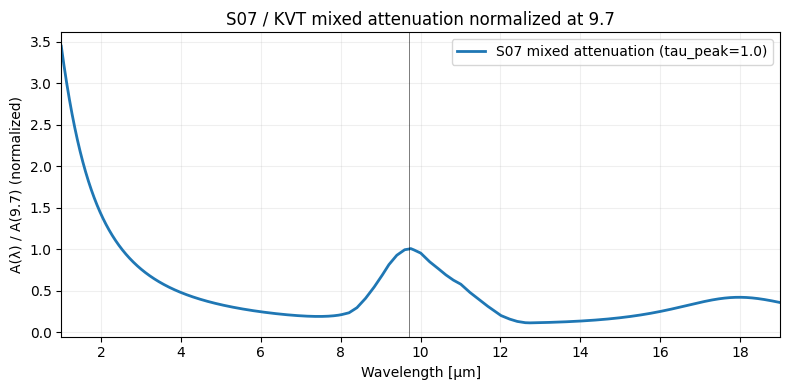

In [4]:


# try to import the PAHFIT component; fallback to local implementation
try:
    from pahfit.fitters.ap_components import S07_attenuation
    use_pahfit = True
except Exception:
    use_pahfit = False

# common wavelength grid (µm)
w = np.linspace(1.0, 19.0, 4000)

if use_pahfit:
    # instantiate with chosen tau_sil
    tau_peak = 1.0
    model = S07_attenuation(tau_sil=tau_peak)
    # model expects numeric wavelengths in microns and returns Att(λ)
    Att = model(w)                      # Att(λ) = (1 - e^-τ)/τ per PAHFIT
    A_lambda = -2.5 * np.log10(Att)
else:
    # local reproduction: KVT silicate + power-law continuum (PAHFIT style)
    kvt_wav = np.array([8.0,8.2,8.4,8.6,8.8,9.0,9.2,9.4,9.6,9.7,9.75,9.8,10.0,10.2,10.4,10.6,10.8,11.0,11.2,11.4,11.6,11.8,12.0,12.2,12.4,12.6,12.7])
    kvt_int = np.array([.06,.09,.16,.275,.415,.575,.755,.895,.98,.99,1.0,.99,.94,.83,.745,.655,.58,.525,.43,.35,.27,.20,.13,.09,.06,.045,.04314])
    # interpolate and taper silicate to avoid edges
    k_sil = np.interp(w, kvt_wav, kvt_int, left=0.0, right=0.0)
    # normalize k_sil peak near 9.7
    k_peak = np.interp(9.7, w, k_sil)
    k_sil_norm = k_sil / (k_peak + 1e-300)
    # continuum shape (power law index ~1.7), normalized at 9.7
    lam0 = 9.7
    index = 1.7
    k_cont = (w / lam0) ** (-index)
    k_cont_norm = k_cont / np.interp(lam0, w, k_cont)
    # combine silicate + continuum
    f_sil = 0.9         # fraction of silicate contribution; tune as needed
    k_comb = f_sil * k_sil_norm + (1.0 - f_sil) * k_cont_norm
    # build τ(λ) and mixed attenuation
    tau_peak = 1.0
    tau_lambda = tau_peak * k_comb
    tau_safe = tau_lambda + 1e-300
    Att = (1.0 - np.exp(-tau_safe)) / tau_safe
    A_lambda = -2.5 * np.log10(Att)

# normalize final magnitudes so A(9.7) = 1
A_ref = np.interp(9.7, w, A_lambda)
A_norm = A_lambda / (A_ref + 1e-300)

# plot normalized attenuation curve
plt.figure(figsize=(8,4))
plt.plot(w, A_norm, lw=2, label=f'S07 mixed attenuation (tau_peak={tau_peak})')
plt.axvline(9.7, color='k', lw=0.6, alpha=0.6)
plt.xlim(1, 19)
plt.xlabel('Wavelength [µm]')
plt.ylabel('A(λ) / A(9.7) (normalized)')
plt.title('S07 / KVT mixed attenuation normalized at 9.7')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


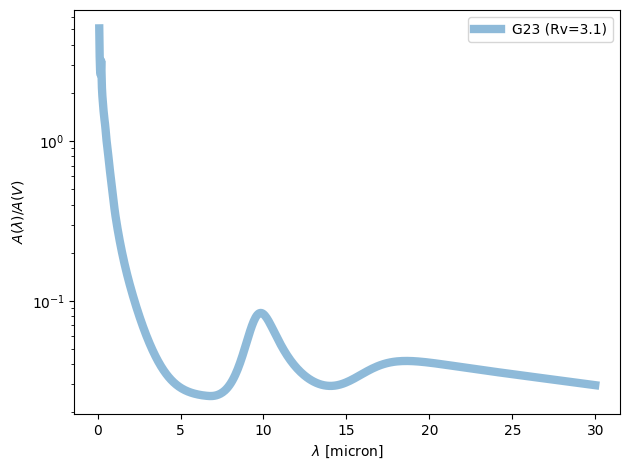

In [6]:
# This is G23 model by calling dust_extinction

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from dust_extinction.parameter_averages import G23

# define the model
extmod = G23(Rv=3.1)

# wavelengths as 1D arrays
wavelengths = np.logspace(np.log10(0.1), np.log10(30.0), num=1000)*u.micron

# extinction at the wavelengths
ext = extmod(wavelengths)

# plot the intrinsic and extinguished fluxes
fig, ax = plt.subplots()

ax.plot(wavelengths, ext, label='G23 (Rv=3.1)', linewidth=6, alpha=0.5)

ax.set_xlabel(r'$\lambda$ [{}]'.format(wavelengths.unit))
ax.set_ylabel(r'$A(\lambda)/A(V)$')

#ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

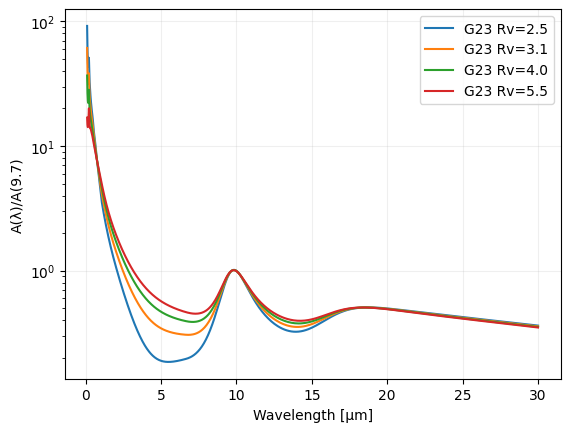

In [7]:
# For variable sizes
from dust_extinction.parameter_averages import G23
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

w = np.logspace(np.log10(0.1), np.log10(30), 1000) * u.micron

for Rv in [2.5, 3.1, 4.0, 5.5]:
    ext = G23(Rv=Rv)
    A = np.asarray(ext(w))
    A_norm = A / np.interp(9.7, w.value, A)
    plt.plot(w.value, A_norm, label=f'G23 Rv={Rv}')

plt.yscale('log')
plt.xlabel('Wavelength [µm]')
plt.ylabel('A(λ)/A(9.7)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


### PAHFIT

#### These are done after I have successfully incorporated all these extnction laws into PAHFIT
#### They wont run unless you do the same
#### The readmme file should contain information on how to do that
#### I might also upload costum PAHFIT model and you should be able to have that access

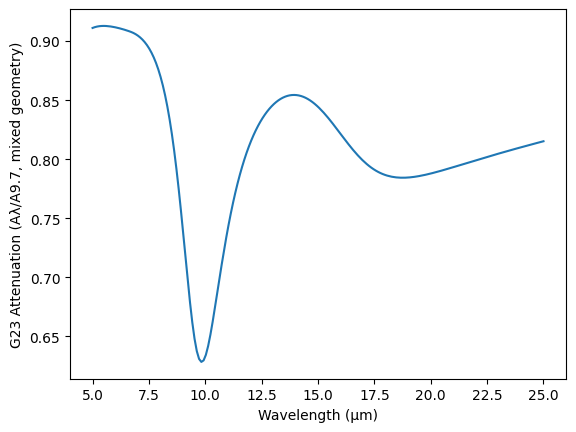

In [15]:
from pahfit.fitters.ap_components import G23_attenuation
import numpy as np

w = np.linspace(5, 25, 200)  # microns
att = G23_attenuation(tau_sil=1.0)
A = att(w)
import matplotlib.pyplot as plt
plt.plot(w, A)
plt.xlabel("Wavelength (µm)")
plt.ylabel("G23 Attenuation (Aλ/A9.7, mixed geometry)")
plt.show()


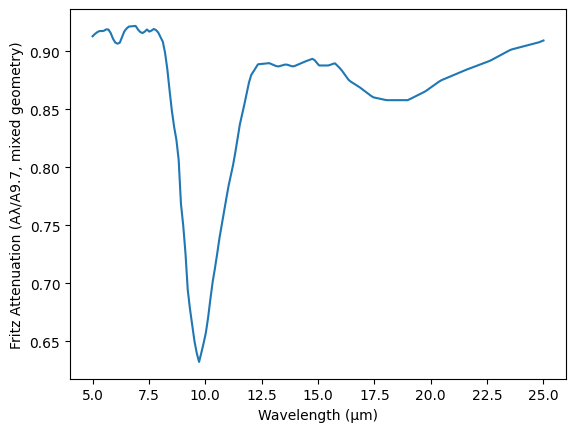

In [2]:
from pahfit.fitters.ap_components import Fritz_attenuation
import numpy as np
import matplotlib.pyplot as plt

w = np.linspace(5, 25, 200)  # microns
att = Fritz_attenuation(tau_sil=1.0)
A = att(w)

plt.plot(w, A)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Fritz Attenuation (Aλ/A9.7, mixed geometry)")
plt.show()


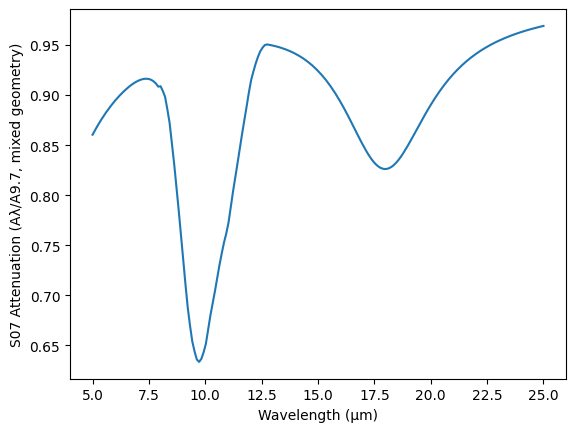

In [17]:
from pahfit.fitters.ap_components import S07_attenuation
import numpy as np
import matplotlib.pyplot as plt

w = np.linspace(5, 25, 200)  # microns
att = S07_attenuation(tau_sil=1.0)
A = att(w)

plt.plot(w, A)
plt.xlabel("Wavelength (µm)")
plt.ylabel("S07 Attenuation (Aλ/A9.7, mixed geometry)")
plt.show()


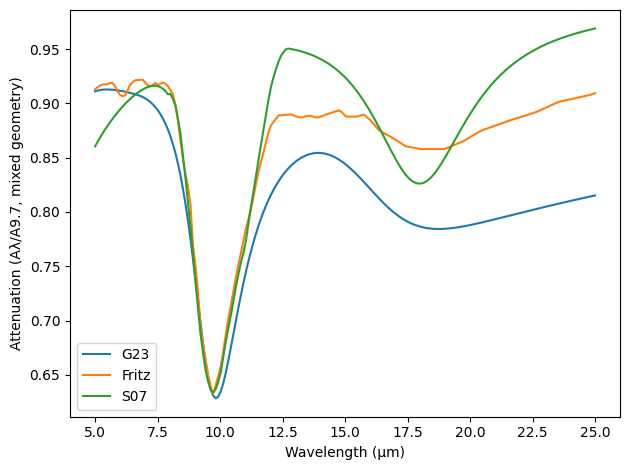

In [1]:
from pahfit.fitters.ap_components import G23_attenuation, Fritz_attenuation, S07_attenuation
import numpy as np
import matplotlib.pyplot as plt

w = np.linspace(5, 25, 200)  # microns

A_g23 = G23_attenuation(tau_sil=1.0)(w)
A_fritz = Fritz_attenuation(tau_sil=1.0)(w)
A_s07 = S07_attenuation(tau_sil=1.0)(w)

plt.plot(w, A_g23, label='G23')
plt.plot(w, A_fritz, label='Fritz')
plt.plot(w, A_s07, label='S07')

plt.xlabel("Wavelength (µm)")
plt.ylabel("Attenuation (Aλ/A9.7, mixed geometry)")
plt.legend()
plt.tight_layout()
plt.show()


### Junks

#### below are some playaround only most of them helped me question my task and correct any inconsistency

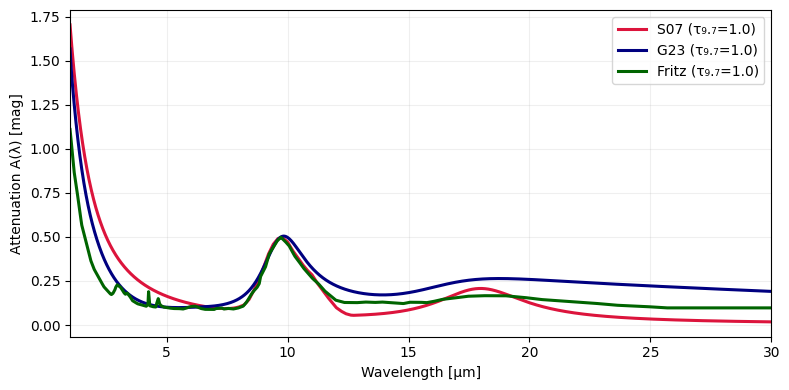

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pahfit.fitters.ap_components import S07_attenuation, Fritz_attenuation
from pahfit.model import G23_attenuation

# Wavelength grid
w = np.linspace(1.0, 30.0, 4000)
tau_peak = 1.0  # Optical depth at 9.7 µm

# --- S07 ---
model_S07 = S07_attenuation(tau_sil=tau_peak)
Att_S07 = np.asarray(model_S07(w))
A_S07 = -2.5 * np.log10(Att_S07)

# --- G23 ---
model_G23 = G23_attenuation(tau_sil=tau_peak)
Att_G23 = np.asarray(model_G23(w))
A_G23 = -2.5 * np.log10(Att_G23)

# --- Fritz ---
model_Fritz = Fritz_attenuation(tau_sil=tau_peak)
Att_Fritz = np.asarray(model_Fritz(w))
A_Fritz = -2.5 * np.log10(Att_Fritz)

# --- Plot all three ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(w, A_S07, color='crimson', lw=2.2, label='S07 (τ₉.₇=1.0)')
ax.plot(w, A_G23, color='navy', lw=2.2, label='G23 (τ₉.₇=1.0)')
ax.plot(w, A_Fritz, color='darkgreen', lw=2.2, label='Fritz (τ₉.₇=1.0)')

ax.set_xlim(1, 30)
ax.set_xlabel('Wavelength [µm]')
ax.set_ylabel('Attenuation A(λ) [mag]')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()


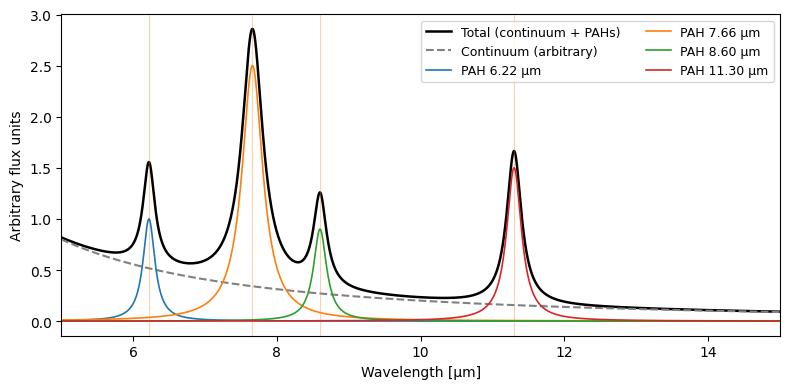

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def drude(w, lam0, gamma, amp):
    """Drude profile in wavelength space (w, lam0, gamma in same units)."""
    g2 = (gamma / 2.0)**2
    return amp * (g2 / ((w - lam0)**2 + g2))

# wavelength grid (µm)
w = np.linspace(5.0, 15.0, 3000)

# example PAH band parameters: (center, width, amplitude)
# these are illustrative — tune amps/widths to match data
pah_params = [
    (6.22, 0.20, 1.0),   # 6.2 µm
    (7.66, 0.35, 2.5),   # 7.7 complex
    (8.60, 0.22, 0.9),   # 8.6 µm
    (11.30, 0.25, 1.5),  # 11.3 µm
]

# build model: continuum + sum of Drudes
cont = 0.2 * (w / 10.0) ** -2.0   # simple falling continuum (arbitrary units)
pah_sum = np.zeros_like(w)
for lam0, gamma, amp in pah_params:
    pah_sum += drude(w, lam0, gamma, amp)

model_total = cont + pah_sum

# plot
plt.figure(figsize=(8,4))
plt.plot(w, model_total, color='k', lw=1.8, label='Total (continuum + PAHs)')
plt.plot(w, cont, '--', color='gray', label='Continuum (arbitrary)')
for lam0, _, _ in pah_params:
    plt.axvline(lam0, color='C1', alpha=0.35, lw=0.8)

# optionally plot individual bands
for lam0, gamma, amp in pah_params:
    plt.plot(w, drude(w, lam0, gamma, amp), lw=1.2, label=f'PAH {lam0:.2f} µm')

plt.xlim(5, 15)
plt.xlabel('Wavelength [µm]')
plt.ylabel('Arbitrary flux units')
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
